In [1]:
# Import packages
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import os
import missingno as msno


# Set output file destination
file_dest = os.getcwd() + "/data/"

# Web Scraping Historic ADP Data (2013 - 2021)

In [2]:
def myleague_adp_data(year):
    '''
    Function to scrape ADP (average draft position) data from https://api.myfantasyleague.com/
    This returns all players who were drafted in at least 5% of leagues
    '''
    # Remove warnings
    pd.options.mode.chained_assignment = None
    
    # URL constants
    base_url = 'https://api.myfantasyleague.com/'
    url_spec = '/reports?R=ADP&POS=RB%2BWR%2BTE&ROOKIES=0&CUTOFF=5&FCOUNT=0&IS_PPR=1&IS_KEEPER=N&IS_MOCK=1&PERIOD=AUG15'
    
    # Extract table HTML from input URL
    page = requests.get(base_url + str(year) + url_spec + '&PAGE=ALL')
    soup = BeautifulSoup(page.text, 'lxml')
    table = soup.find('table', attrs={'class': 'report'})
    
    # Convert table HTML to pandas df and clean up
    df = pd.read_html(str(table))[0]
    df.drop(df.tail(1).index, inplace=True) # Drop last row (Page: 1 2 3 4 ALL)
    df['Year'] = year
    df['ADP'] = df['Avg Pick'].astype(float) # Rename column and force to float
    df[['LastName', 'Player']] = df.Player.str.split(", ", expand=True)          # Expand player info across columns
    df[['FirstName', 'Team', 'Position']] = df.Player.str.split(expand=True)     # Ex: McCaffrey, Christian CAR RB
    df['FirstName'] = df['FirstName'].str.replace('[^\w\s]', '', regex=True)     # Remove punctuation
    df['LastName'] = df['LastName'].str.replace('[^\w\s]', '', regex=True)
    df['FirstName'] = df['FirstName'].str.replace('Stevie', 'Steve', regex=True) # Edit names to make consistent
    df = df.reindex(columns=['Rank', 'FirstName', 'LastName', 'Team', 'Position', 'ADP', 'Year']) # Order columns
    df = df[df.Team != "FA"] # Remove free agents
    
    return df


In [3]:
def add_competition_data(adp_df):
    '''
    Function to get positional competition data for each player, including
        - Positional rank on team
        - ADP of teammates in same position
        - Positional ambiguity (T/F)
        - Handcuff (T/F) - not yet added
    '''
    
    # Remove warnings
    pd.options.mode.chained_assignment = None
    
    teams = list(set(adp_df.Team))
    team_dfs = []
    # Get positional competition data for each team by position
    for team in teams:
        team_pos_dfs = [] # List used to store each positional data frame create for a given team
        positions = ['RB', 'WR', 'TE']
        for position in positions:
            
            # Determine positional ranks of players with same team/position
            pos_team_df = adp_df[(adp_df.Team == team) & (adp_df.Position == position)].reset_index(drop=True)
            pos_team_df["TeamPosRank"] = pos_team_df.index + 1
            pos_team_df["TeamPosRank"] = pos_team_df.Position + pos_team_df.TeamPosRank.astype(str)
            
            # Determine ADPs of the lead and secondary position players on the team
            pos_adps = sorted(pos_team_df.ADP)
            
            # RB1/WR1/TE1 ADP in team will be the first element of pos_adps
            try:
                pos1_adp = pos_adps[0]
            except:
                pos1_adp = np.nan
            
            # RB2/WR2/TE2 ADP in team will be the second element of pos_adps
            try:
                pos2_adp = pos_adps[1]
            except:
                pos2_adp = np.nan
            pos_team_df['PosRank1_ADP'] = pos1_adp
            pos_team_df['PosRank2_ADP'] = pos2_adp
            
            # Determine if team position is ambiguous
            # Ambiguous: Multiple players in a position drafted between rounds 4 through 9
            try:
                ambiguous = (pos1_adp > 36) & (pos1_adp <= 108) & (pos2_adp > 36) & (pos2_adp <= 108)
            except:
                ambiguous = False
            pos_team_df["PosAmbiguity"] = ambiguous
            
            # Append data frame to list
            team_pos_dfs.append(pos_team_df)
            
        team_dfs.append(pd.concat(team_pos_dfs))
        
    # Concatenate the data frames created for each team
    output_df = pd.concat(team_dfs).reset_index(drop=True)
    output_df.sort_values(by = 'ADP', inplace = True)
    return output_df


In [4]:
# Create data frame containing all ADP data from 2013 to 2021
years = list(np.arange(2013, 2022))
adp_df = [myleague_adp_data(year) for year in years] # Scrape all data
adp_df = [add_competition_data(df) for df in adp_df] # Add competition data to all years
adp_df = pd.concat(adp_df)                           # Concatenate data frames from each year
adp_df.dtypes


Rank             object
FirstName        object
LastName         object
Team             object
Position         object
ADP             float64
Year              int64
TeamPosRank      object
PosRank1_ADP    float64
PosRank2_ADP    float64
PosAmbiguity       bool
dtype: object

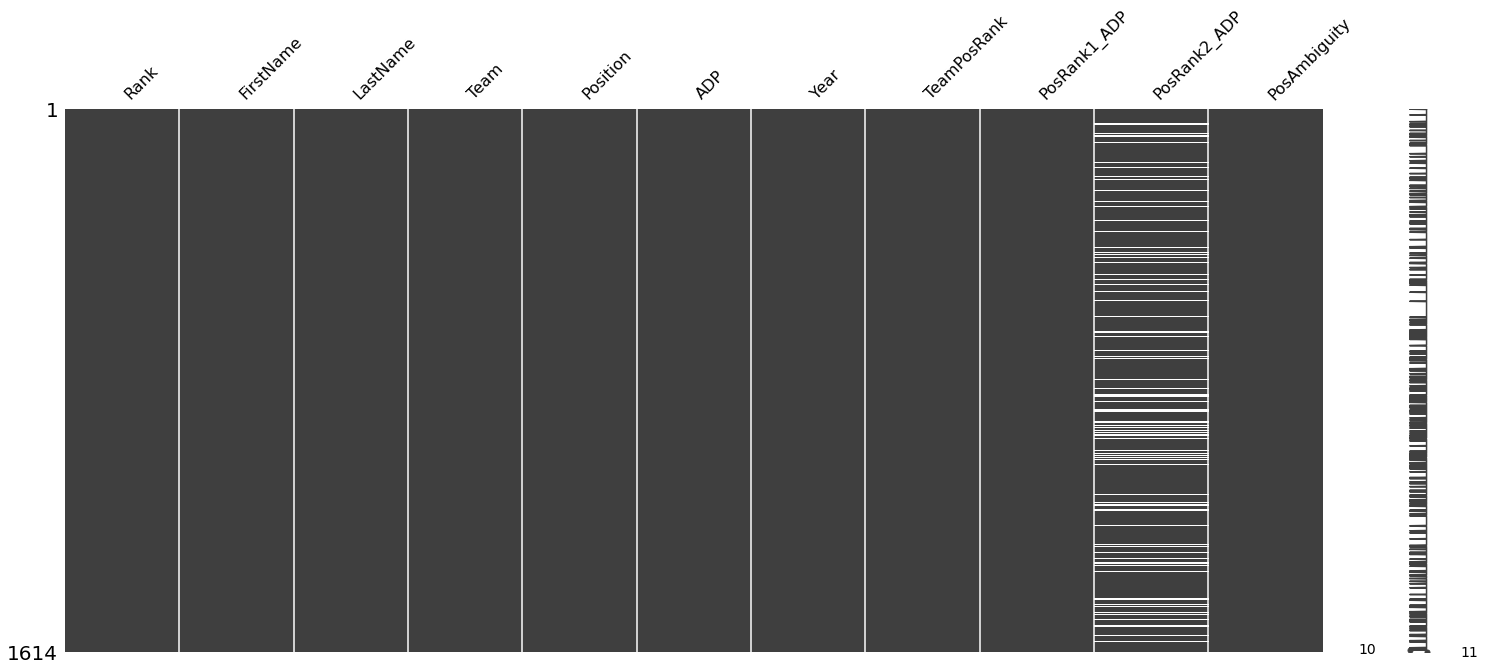

In [5]:
# Checking for missing data
# Some data missing for PosRank2_ADP; will need to work this out before use in ML models
msno.matrix(adp_df)
adp_df.to_csv(file_dest + "ffball_ADP_data_2013-2021.csv", index=False)


# Web Scraping Season Stats (2013 - 2021)

In [6]:
def season_stats(year):
    '''
    Function to get seasonal stats for players
    '''
    
    # Set up query information
    url = "https://fantasydata.com/NFL_FantasyStats/FantasyStats_Read"
    data = {
        "sort": "FantasyPoints-desc",
        "pageSize": "1000",
        "filters.season": str(year),
        "filters.seasontype": "1",
        "filters.scope": "1",
        "filters.subscope": "1",
        "filters.aggregatescope": "1",
        "filters.range": "3"
    }
    
    # Retrieve season stats
    response = requests.post(url, data=data)
    response.raise_for_status()
    df = pd.DataFrame(response.json()["Data"])
    df = df[(df.Position == 'RB') | (df.Position == 'WR') | (df.Position == 'TE')]   # Select RBs, WRs, TEs
    df['Year'] = df.Season                                                           # Rename Season column
    df['GamesPlayed'] = df.Played                                                    # Rename Played column
    # Select and order columns
    df = df.reindex(columns=['FirstName', 'LastName', 'PlayerID', 'Position', 'Year', 'FantasyPointsHalfPointPpr',
                             'FantasyPointsPerGameHalfPointPPR', 'Played', 'RushingAttempts',
                             'RushingYards', 'RushingYardsPerAttempt', 'RushingTouchdowns',
                             'Receptions', 'ReceivingTargets', 'ReceivingYards', 'ReceptionPercentage',
                             'ReceivingTouchdowns', 'ReceivingYardsPerTarget', 'ReceivingYardsPerReception'])
    return df


In [7]:
def clean_names_ssn_stats(df):
    '''
    Function to clean player names to make consistent with the ADP data
    '''
    df['FirstName'] = df['FirstName'].str.replace('[^\w\s]', '', regex=True)       # Remove punctuation
    df['LastName'] = df['LastName'].str.replace('[^\w\s]', '', regex=True)         # Remove punctuation
    df['LastName'] = df['LastName'].str.replace(' II', '', regex=True)             # Edit names for consistency
    df['LastName'] = df['LastName'].str.replace(' III', '', regex=True)            # Edit names for consistency
    df['LastName'] = df['LastName'].str.replace(' IV', '', regex=True)             # Edit names for consistency
    df['LastName'] = df['LastName'].str.replace(' V', '', regex=True)              # Edit names for consistency
    df['LastName'] = df['LastName'].str.replace(' Sr', '', regex=True)             # Edit names for consistency
    df['LastName'] = df['LastName'].str.replace(' Jr', '', regex=True)             # Edit names for consistency
    df['LastName'] = df['LastName'].str.replace('GordonI', 'Gordon', regex=True)   # Edit names for consistency
    df['FirstName'] = df['FirstName'].str.replace('William', 'Will', regex=True)   # Edit names for consistency
    
    return df


In [8]:
# Create data frame containing all stats from 2013 to 2021
years = list(np.arange(2013, 2022))
stats_df = [season_stats(year) for year in years] # Scrape all data
stats_df = pd.concat(stats_df)                    # Concatenate data frames from each year
stats_df = clean_names_ssn_stats(stats_df)
stats_df.to_csv(file_dest + "ffball_stat_data_2013-2021.csv", index=False)
stats_df.dtypes


FirstName                            object
LastName                             object
PlayerID                              int64
Position                             object
Year                                  int64
FantasyPointsHalfPointPpr           float64
FantasyPointsPerGameHalfPointPPR    float64
Played                                int64
RushingAttempts                     float64
RushingYards                        float64
RushingYardsPerAttempt              float64
RushingTouchdowns                   float64
Receptions                          float64
ReceivingTargets                    float64
ReceivingYards                      float64
ReceptionPercentage                 float64
ReceivingTouchdowns                 float64
ReceivingYardsPerTarget             float64
ReceivingYardsPerReception          float64
dtype: object

<AxesSubplot:>

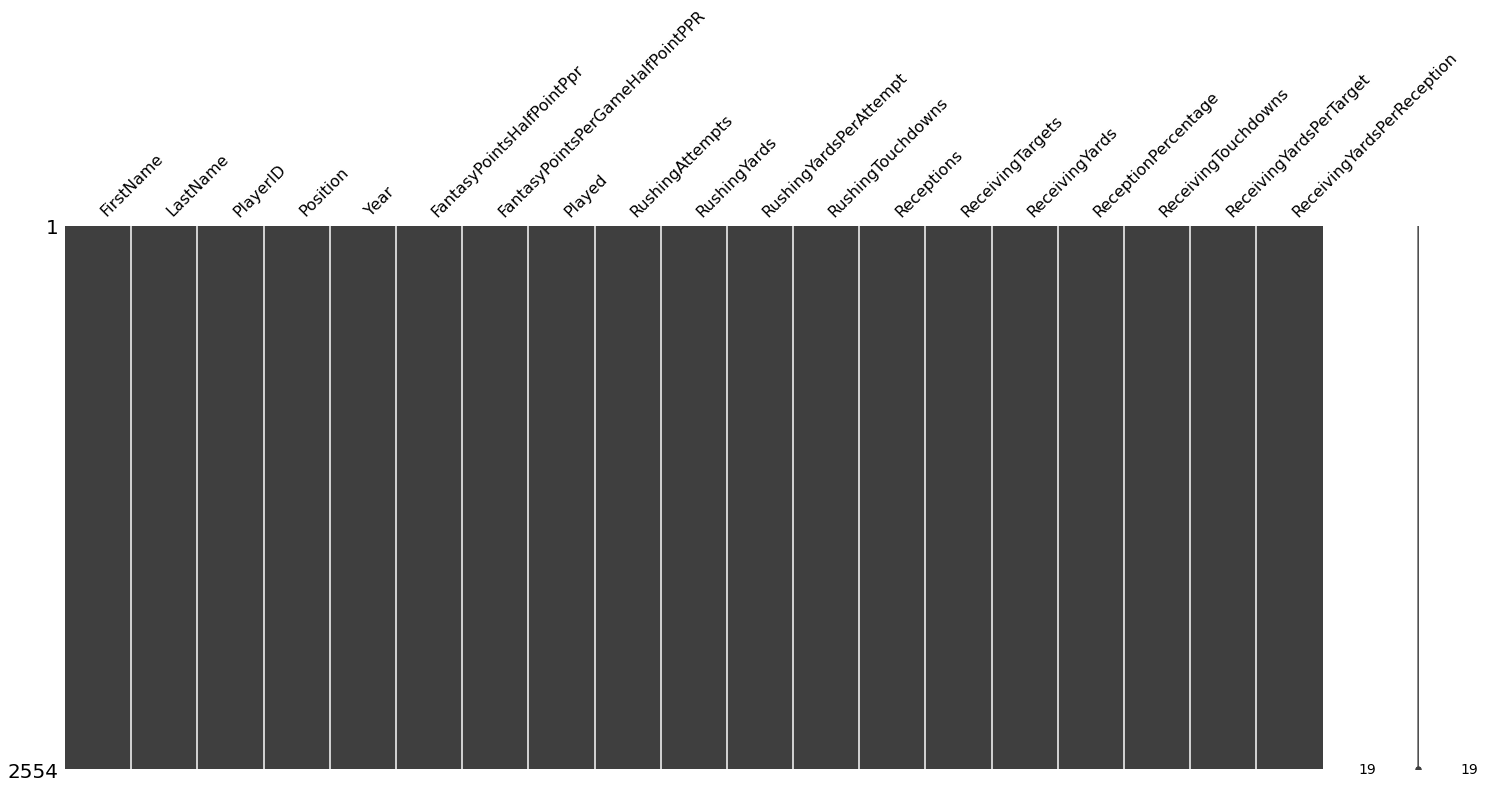

In [9]:
# Checking for missing data - no missing data here
msno.matrix(stats_df)


# Merging ADP & Season Statistics

In [10]:
# Merging the data using "inner" method; will remove players who do not overlap between data sets
all_data = adp_df.merge(stats_df, how="inner")
all_data.to_csv(file_dest + "ffball_ADP&stat_data_2013-2021.csv", index=False)


<AxesSubplot:>

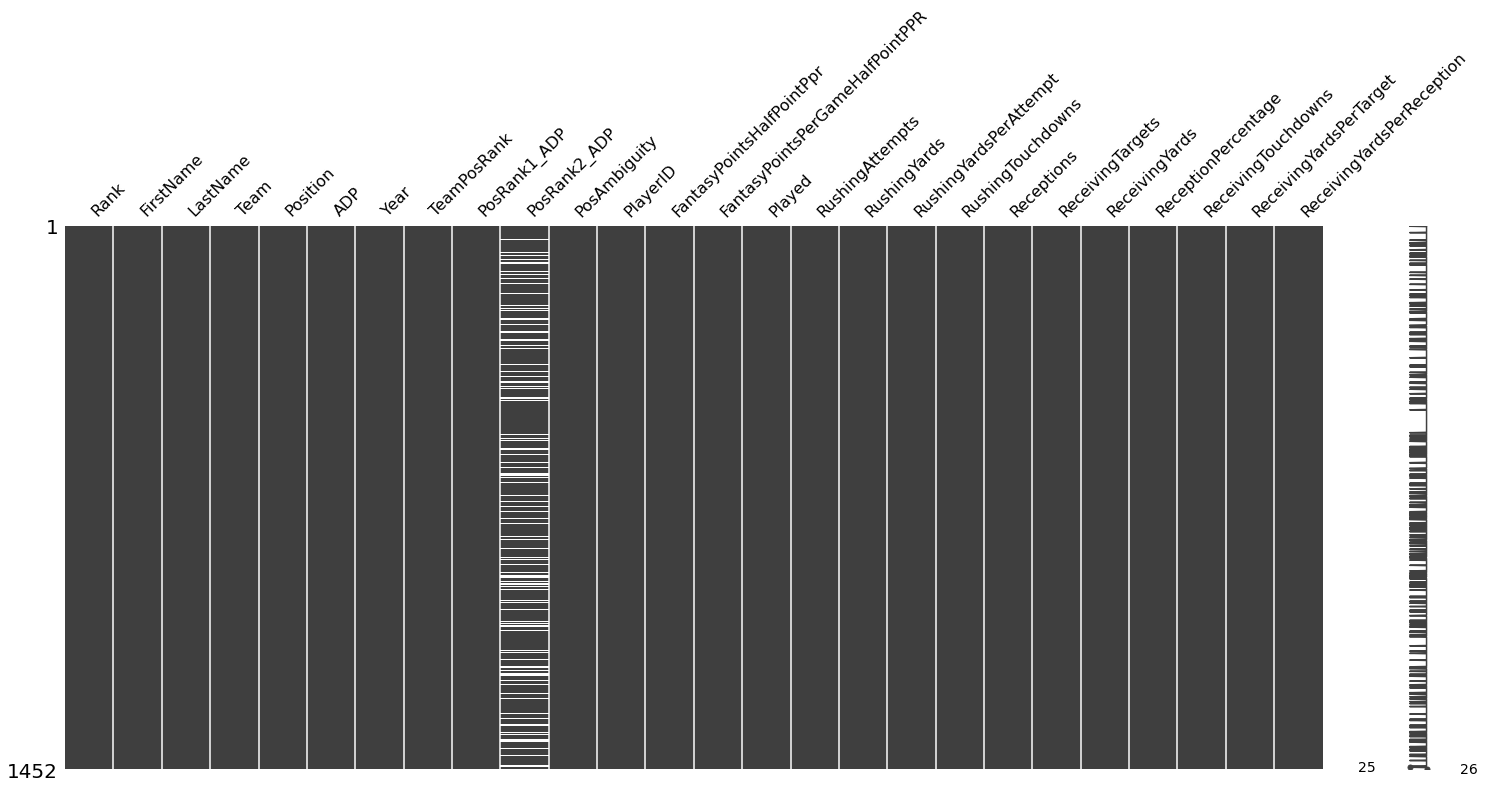

In [11]:
# Checking for missing data - once again missing data for PosRank2_ADP (expected)
msno.matrix(all_data)
            